# Off-Policy Monte Carlo Control with Weighted Importance Sampling

**Monte Carlo (MC) control** is a technique used to learn the optimal policy by estimating the action-value function
𝑄
∗
(
𝑠
,
𝑎
)
Q
∗
 (s,a) using episodes of interaction with the environment. Off-policy learning refers to learning about one policy while following another (i.e., the behavior policy may differ from the target policy we are trying to learn).

 **Weighted Importance Sampling (WIS)** is a technique used in off-policy learning to correct for the mismatch between the behavior policy (the policy used to generate the data) and the target policy (the policy we are trying to improve).

In [1]:
from IPython import get_ipython
from IPython.display import display

%matplotlib inline

import os
os.environ['GYM_DISABLE_ENV_CHECKER'] = '1'

import gym
import matplotlib.pyplot as plt
import numpy as np
import sys

from collections import defaultdict

plt.style.use('ggplot')

In [2]:
env = gym.make("Blackjack-v1")

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [3]:
def create_random_policy(nA):
    """
    Creates a random policy function.

    Args:
        nA: Number of actions in the environment.

    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [4]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.

    Args:
        Q: A dictionary that maps from state -> action values

    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """

    def policy_fn(state):
        A = np.zeros_like(Q[state], dtype=float)
        best_action = np.argmax(Q[state])
        A[best_action] = 1.0
        return A
    return policy_fn

In [7]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.

    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.

    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """

    # The final action-value function.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # The cumulative denominator of the weighted importance sampling formula (across all episodes)
    C = defaultdict(lambda: np.zeros(env.action_space.n))

    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)

    for i_episode in range(1, num_episodes + 1):

        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Generate an episode.
        episode = []
        state = env.reset()
        for t in range(100):

            probs = behavior_policy(state)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            if done:
                break
            state = next_state


        G = 0.0
        W = 1.0

        # For each step in the episode, backwards
        for t in range(len(episode))[::-1]:
            state, action, reward = episode[t]

            # Update the total reward since step t
            G = discount_factor * G + reward

            # Update weighted importance sampling formula denominator
            C[state][action] += W

            # Update the action-value function using the incremental update formula (5.7)
            # This also improves our target policy which holds a reference to Q
            Q[state][action] += (W / C[state][action]) * (G - Q[state][action])

            # If the action taken by the behavior policy is not the action
            # taken by the target policy the probability will be 0 and we can break
            if action !=  np.argmax(target_policy(state)):
                break
            W = W * 1./behavior_policy(state)[action]

    return Q, target_policy

In [8]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

In [10]:
import gym
from IPython import display
import numpy as np
import pandas as pd
from collections import namedtuple
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
%matplotlib inline

EpisodeStats = namedtuple('Stats', ['episode_lengths', 'episode_rewards'])


def plot_value_function(V, title = "Value Function"):
    '''
    Plots the value function as a surface plot.
    '''
    min_x = 11 # min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize = (20, 10))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.coolwarm, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



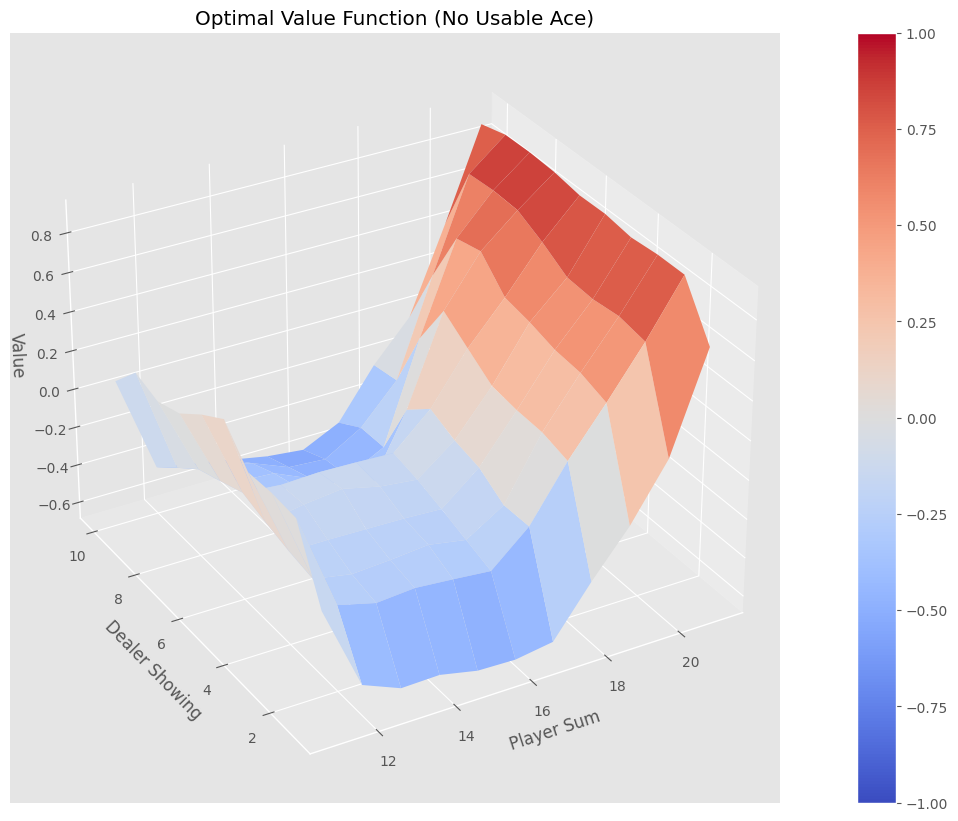

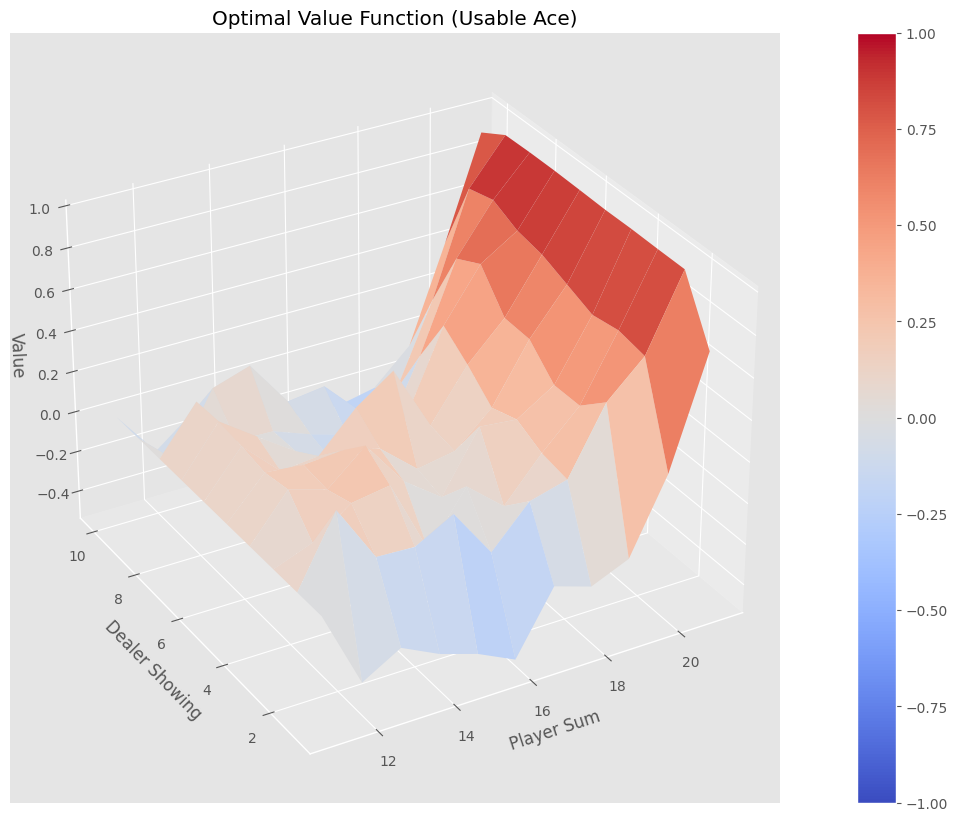

In [11]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function")